In [73]:
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy.stats import describe
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import pairwise_distances_argmin
from matplotlib import pyplot as plt
from matplotlib import cm

%matplotlib notebook

In [2]:
# Import the data
X = pd.read_csv('data/training_templates.csv', header=None)
y = np.loadtxt('data/training_labels.txt', dtype=np.int)
X_pred = pd.read_csv('data/testing_templates.csv', header=None)

In [3]:
# Define scoring methods
def compute_pred_score(y_true, y_pred):
    """
    One error costs 10, a line that remains unlabeled costs 1
    """
    y_comp = y_true * y_pred
    return float(10 * np.sum(y_comp == -1) + np.sum(y_comp == 0)) / y_comp.shape[0]


def scoring(clf):
    """
    Given a classifier and a test set, calculate the best threshold for the probability
    that indicates if a points should be labeled or not, and return the corresponding score.
    """
    pred_orig = clf.predict(X_test)
    probas = clf.predict_proba(X_test)

    best_error = 999.
    best_proba = 0.5
    for min_proba in np.arange(best_proba, 1., 0.01):
        pred = pred_orig
        indices = [i for i, p in enumerate(probas) if p[0] < min_proba and p[1] < min_proba]
        pred[indices] = 0
        error = compute_pred_score(y_test, pred)
        if error < best_error:
            best_proba = min_proba
            best_error = error

    return best_score, best_proba

## First, let us look at the data

In [4]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,...,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000,105600.000000
mean,0.002530,0.009891,0.003773,-0.001822,-0.005840,0.006133,-0.001196,0.000269,0.003189,0.027155,...,-0.007751,0.000872,0.013127,0.004349,-0.008010,-0.009650,-0.004151,0.018330,0.003536,0.011311
std,0.088575,0.088537,0.085500,0.088032,0.088861,0.087878,0.087473,0.087020,0.088854,0.087430,...,0.088984,0.086749,0.089278,0.087563,0.089629,0.086063,0.086820,0.086243,0.087852,0.087984
min,-0.374050,-0.343089,-0.370593,-0.350701,-0.372002,-0.362833,-0.346995,-0.356012,-0.360777,-0.382042,...,-0.389960,-0.427322,-0.335887,-0.363706,-0.364123,-0.342469,-0.345809,-0.342626,-0.328322,-0.337600
25%,-0.057137,-0.050926,-0.054950,-0.062391,-0.066306,-0.053921,-0.061468,-0.059135,-0.057454,-0.032391,...,-0.067861,-0.058948,-0.047982,-0.054972,-0.069366,-0.068553,-0.064037,-0.040636,-0.056550,-0.048836
50%,0.002770,0.010483,0.002933,-0.002886,-0.005265,0.006131,-0.001636,0.000509,0.003147,0.028051,...,-0.007069,0.000445,0.013359,0.005009,-0.007677,-0.010149,-0.005142,0.017391,0.004375,0.012039
75%,0.062636,0.071121,0.061925,0.057764,0.055694,0.066336,0.057812,0.060063,0.063074,0.087598,...,0.053417,0.059779,0.074721,0.064479,0.053816,0.049220,0.054491,0.077035,0.063698,0.072093
max,0.372737,0.365854,0.354075,0.336738,0.383177,0.383389,0.376780,0.349109,0.332908,0.404551,...,0.348946,0.378057,0.350320,0.324484,0.330347,0.374871,0.372385,0.365373,0.386366,0.351534


In [86]:
for col in X:
    desc = describe(X[col])
    print('{:3} - skewness: {:+1.5f}\tkurtosis: {:1.5f}\n'.format(col, desc.skewness, desc.kurtosis))

  0 - skewness: -0.01109	kurtosis: -0.04614

  1 - skewness: -0.04700	kurtosis: -0.16244

  2 - skewness: +0.03772	kurtosis: -0.09666

  3 - skewness: +0.05476	kurtosis: -0.10440

  4 - skewness: -0.03046	kurtosis: -0.13335

  5 - skewness: -0.00216	kurtosis: -0.10896

  6 - skewness: +0.05687	kurtosis: -0.05982

  7 - skewness: -0.02207	kurtosis: -0.10889

  8 - skewness: -0.00101	kurtosis: -0.07914

  9 - skewness: -0.05387	kurtosis: -0.14290

 10 - skewness: -0.01051	kurtosis: -0.10508

 11 - skewness: +0.01991	kurtosis: -0.03617

 12 - skewness: -0.04385	kurtosis: -0.12381

 13 - skewness: +0.05512	kurtosis: -0.12849

 14 - skewness: -0.00209	kurtosis: -0.13982

 15 - skewness: +0.02398	kurtosis: -0.10449

 16 - skewness: +0.03385	kurtosis: -0.10020

 17 - skewness: -0.03062	kurtosis: -0.02277

 18 - skewness: -0.04315	kurtosis: -0.01002

 19 - skewness: +0.10165	kurtosis: -0.07333

 20 - skewness: -0.00001	kurtosis: -0.08808

 21 - skewness: +0.01669	kurtosis: -0.10030

 22 - skew

<IPython.core.display.Javascript object>


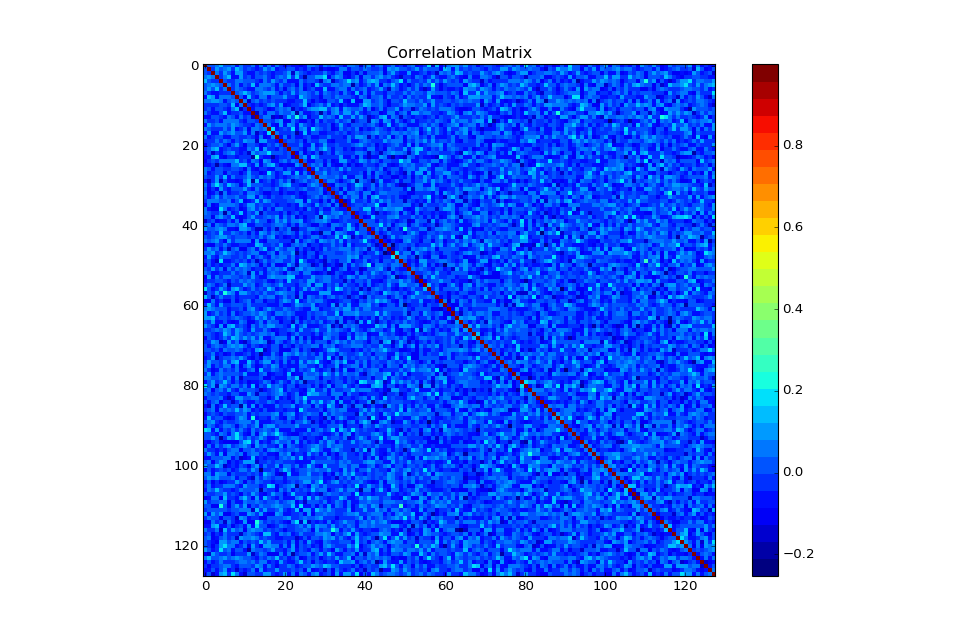

In [24]:
fig = plt.figure(figsize=(12, 8))
cmap = cm.get_cmap('jet', 30)
correlations_X = X.corr()
cax = plt.imshow(correlations_X, interpolation="nearest", cmap=cmap)
plt.title('Correlation Matrix')
cbar = fig.colorbar(cax, ticks=np.arange(-1., 1., 0.2))
plt.show()

### Il ne semble pas y avoir de corrélation prononcée entres les variables, tout porte à croire qu'elles sont indépendantes

In [32]:
n, p = X.shape
print('La plus forte corrélation entre 2 variables explicatives est de:')
np.max([abs(correlations_X.loc[i, j]) for i in range(p) for j in range(i)])

La plus forte corrélation entre 2 variables explicatives est de:


0.27441455066100251

<IPython.core.display.Javascript object>


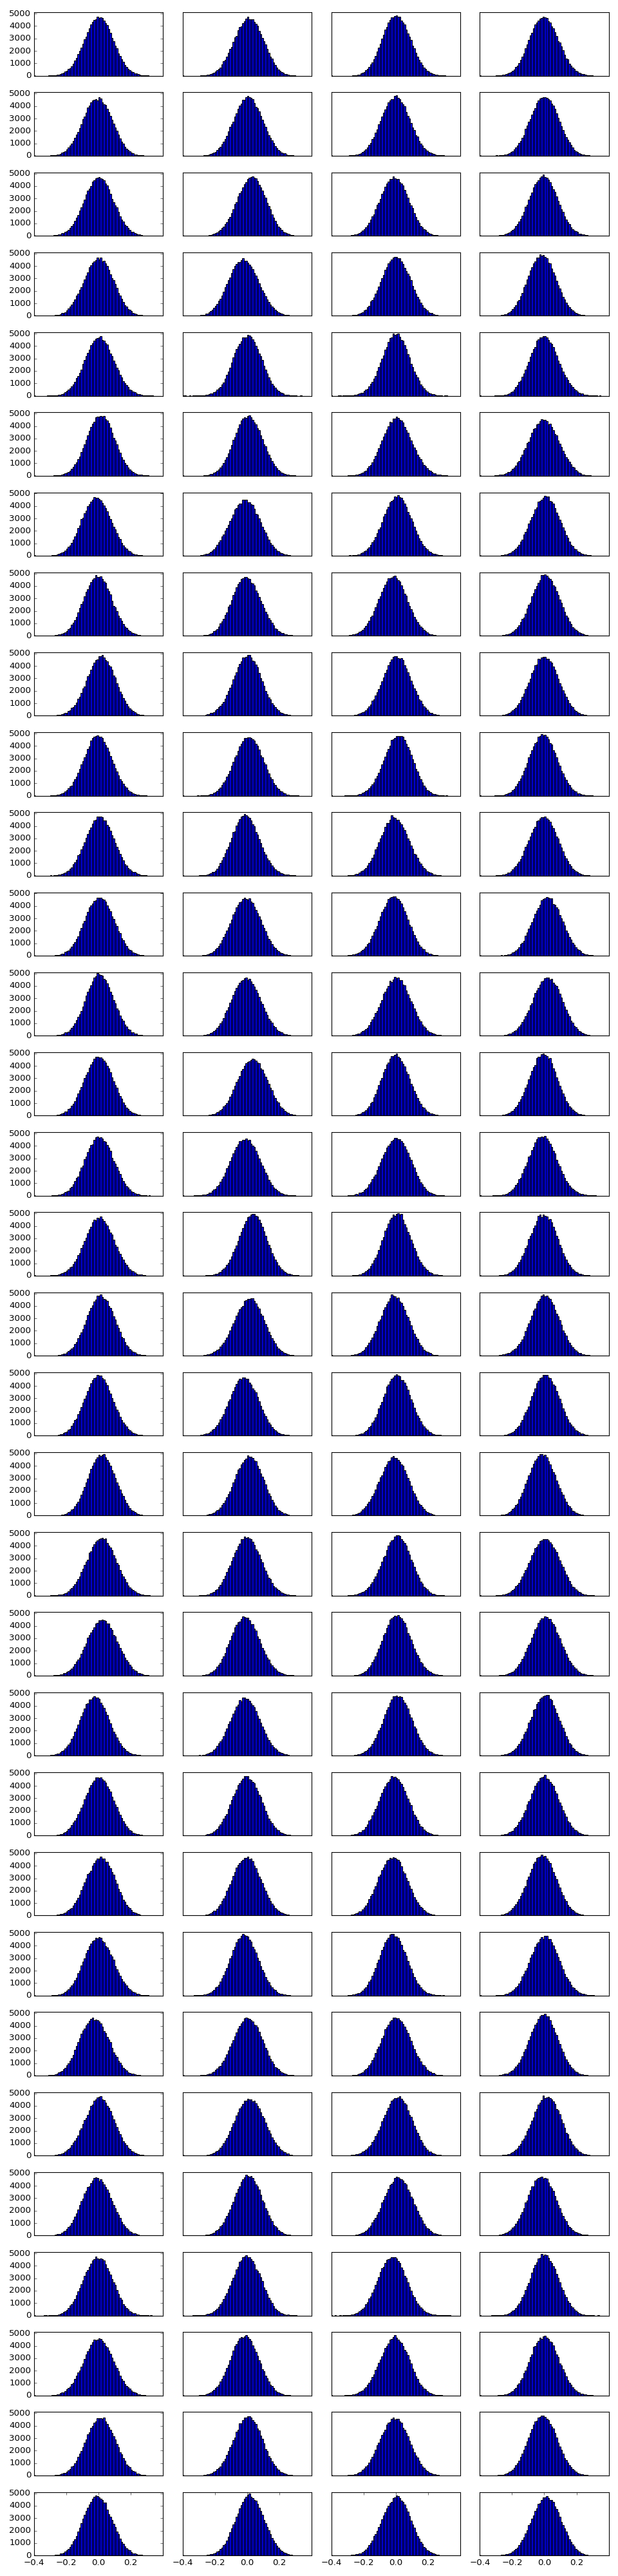

In [61]:
plt.figure(figsize=(12, 50))
for i, col in enumerate(X):
    plt.subplot(32, 4, i+1)
    plt.xticks([] if i < 124 else np.arange(-.4, .4, .2))
    plt.yticks([] if i%4!=0 else np.arange(0, 5100, 1000))
    plt.ylim(ymin=0, ymax=5100)
    plt.xlim(xmin=-0.4, xmax=0.4)
    plt.hist(X[col], bins=np.arange(-0.4, 0.4, 0.01))

plt.tight_layout()

Les kurtosis calculées précédemment semblaient indiquer des gaussiennes, ces histogrammes nous le confirment.

## Etude de y

In [70]:
for v in np.unique(y):
    print('Number of', v, ':', np.sum(y==v))

Number of -1 : 52800
Number of 1 : 52800


Pour y, l'étude est rapide et montre que nous avons autant d'hommes que de femmes dans l'échantillon.